
              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.7.0
 Built: Jun 14 2024 10:44:24

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.

 Build the PRE-neuron ------------------
Mar 28 14:44:20 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

 Build the POST-neuron ------------------
 Create and connect spike generators ------------------
Connect pre_neuron -> post_neuron ------------------
Create and connect spike recorders  ------------------
Create and connect multimeters  ------------------
Simulate in steps  ------------------
Saved synaptic weight evolution to 'weights_alpha_forced_pl.csv'
Saved spikes of pre_neurons to 'spikes_pre_neurons.csv'
Saved spikes of post_neurons to 'spikes_post_neurons.csv'
Saved synaptic weight plot to 'weights_alpha_fo

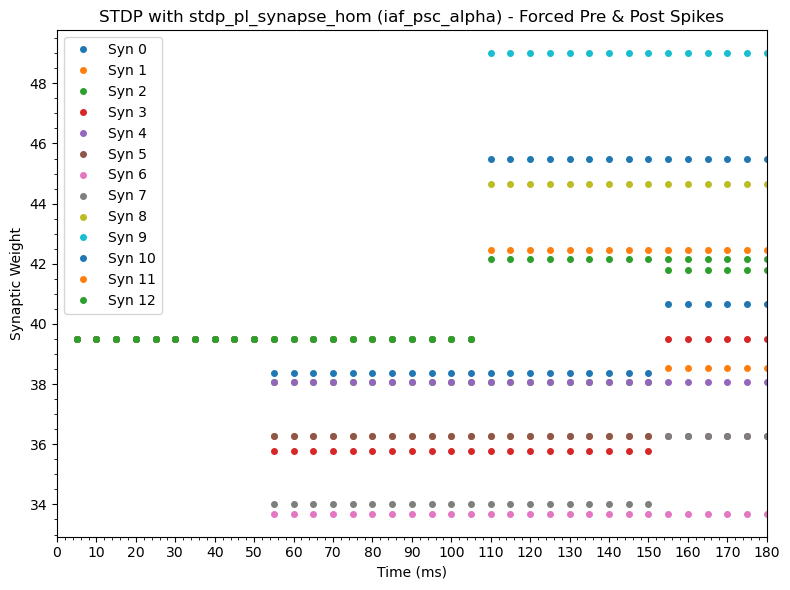

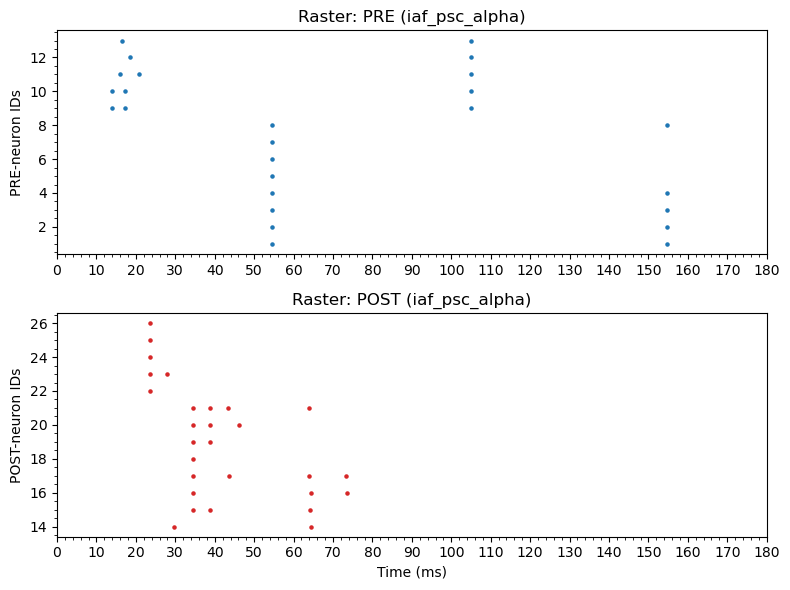

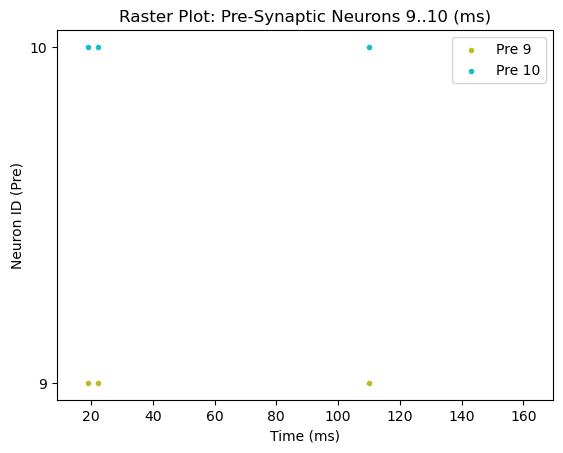

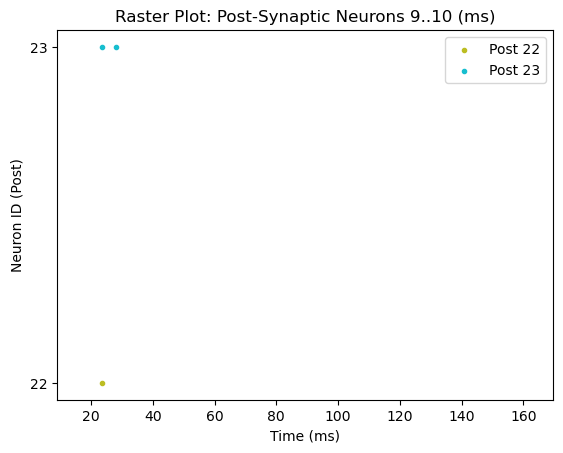

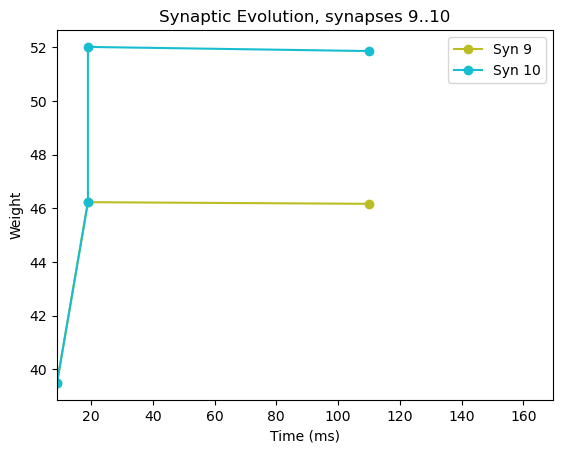

In [1]:
import os
import matplotlib as plt
from get_script_dir import *
from sim_stdp_alpha_forced_pl_lib import sim_stdp_alpha_forced_pl
from predict_stdp_alpha_forced_pl_lib import predict_stdp_alpha_forced_pl

def compare_csv_files(csv_file_1, csv_file_2, threshold=1e-8):
    """
    Compare 'syn_ID', 'start_syn_value', 'final_syn_value' row-by-row
    with a relative difference threshold. Return True if all OK, else False.
    """
    df1 = pd.read_csv(csv_file_1).sort_values(by='syn_ID').reset_index(drop=True)
    df2 = pd.read_csv(csv_file_2).sort_values(by='syn_ID').reset_index(drop=True)

    needed_cols = ['syn_ID', 'start_syn_value', 'final_syn_value']
    for col in needed_cols:
        if col not in df1.columns or col not in df2.columns:
            print(f"Missing column '{col}' in one of the CSVs.")
            return False

    if len(df1) != len(df2):
        print("Mismatch in row counts.")
        return False

    for i in range(len(df1)):
        syn_id_1 = df1.loc[i, 'syn_ID']
        syn_id_2 = df2.loc[i, 'syn_ID']
        if syn_id_1 != syn_id_2:
            print(f"Row {i} mismatch in syn_ID: {syn_id_1} vs {syn_id_2}")
            return False

        for col in ['start_syn_value', 'final_syn_value']:
            val1 = df1.loc[i, col]
            val2 = df2.loc[i, col]
            denom = max(1e-15, abs(val1), abs(val2))
            rel_diff = abs(val1 - val2)/denom
            if rel_diff > threshold:
                print(f"Row {i}, syn_ID={syn_id_1}, col={col} mismatch: {val1} vs {val2}, rel_diff={rel_diff}")
                return False

    print(f"Files {csv_file_1} and {csv_file_2} match within threshold={threshold}.")
    return True

        
if __name__ == "__main__":
    # sim 1)
    current_dir = get_script_dir()
    config_file = os.path.join(current_dir, "config_sim_test_Ax_and_Dendr_Delay_STDP.yaml")
    df_w, sim_summary, plot_display = sim_stdp_alpha_forced_pl(config_file)
    #print("df_w",df_w)
    
    # sim 2) Convert the dictionary to a Pandas DataFrame
    #    Each dictionary entry has keys: ["syn_ID", "start_syn_value", "final_syn_value"]
    df_sim_summary = pd.DataFrame.from_dict(sim_summary, orient='index')

    
    # sim 3) Save to CSV
    output_sim_csv = "sim_summary.csv"
    df_sim_summary.to_csv(output_sim_csv, index=False)
    print(f"Simulation summary saved to {output_sim_csv}.")

    # prediction 1) Run the STDP routine, which returns a dictionary
    config_check_stdp_filename = "config_sim_test_Ax_and_Dendr_Delay_STDP.yaml"
    config_file = os.path.join(current_dir, config_check_stdp_filename)
    prediction_summary = predict_stdp_alpha_forced_pl(config_file)
    
    # prediction 2) Convert the dictionary to a Pandas DataFrame
    #    Each dictionary entry has keys: ["syn_ID", "start_syn_value", "final_syn_value",
    #                                     "axonal_delay", "dendritic_delay"]
    df_summary = pd.DataFrame.from_dict(prediction_summary, orient='index')
    
    # prediction 3) Save to CSV
    output_csv = "prediction_summary.csv"
    df_summary.to_csv(output_csv, index=False)
    print(f"Prediction summary saved to {output_csv}.")

    
    # 4) Compare the two CSVs
    match_ok = compare_csv_files("prediction_summary.csv", "sim_summary.csv", threshold=1e-8)
    if match_ok:
        print("Both CSV files match within threshold.")
    else:
        print("Mismatch found above threshold.")
        assert("MISMATCH DETECTED")

    # Show all plots
    if plot_display:
        plt.show()
    